# K-means
See the more general notebook on Clustering.

Here, we implement K-means Clustering from scratch.

To keep it simple, use only one feature i.e. one dimension.
The algorithm must slide the means left & right to find optimal.

Implementing our code, we compute and display SSE
to show that it reduces as the means approach 20 and 40. 
However, our topping criteria was delta mean, not SSE.

Testing our code, we found the initializers made a big difference.
The code often generated poor results when given bad initial values.

This code is designed for K=2. 
That simplifies the situation.
We only need to test two means for each point's cluster membership.
The distance calculation is scalar not vector.

This code is designed for #features=1.
That simplifies the situation.
Each distance from the mean is computed by 
simple subtraction along X axis.
For additional features, each point and mean would be a vector.
We would use element-wise subtraction to determine convergence, 
and norm=np.linalg.norm(diff)
i.e. sqrt of sum of squares of differences per dimension.

Our code can crash on divide by zero,
but this only happens with bad initial guesses 
outside the acutal (random) data range, such as
(0,0) or (0,1) or (1,2) or (100,200).
We saw fast convergence with parameters near the extremes
such as (10,50) .
We saw eventual convergence with means like 
(20,21) or (40,41) or (60,61).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [2]:
def distance(p1,p2):
    # Compute the norm of the distance between points p1 and p2.
    # For single-feature data, all the norms are equivalent.
    # For Kmeans in higher dimensions, the L2 norm is used.
    # Althouth L1 is simply abs(p1-p2),
    # and sqrt of square is a wasteful identity op,
    # we'll use L2 to be pedantic.
    return np.sqrt((p1-p2)**2)
def is_closer(point,this_mean,that_mean):
    return distance(point,this_mean) < distance(point,that_mean)
def sse(vector,mean):
    err=vector-mean
    se=np.square(err)
    sse=sum(se)
    return int(sse)
def assign_clusters(mean1,mean2,data):
    clust1=np.asarray([x for x in data if is_closer(x,mean1,mean2)])
    clust2=np.asarray([x for x in data if is_closer(x,mean2,mean1)])
    print('Cluster sizes:',len(clust1),len(clust2))
    return clust1,clust2
def recompute_means(clust1,clust2):
    mean1=np.mean(clust1)
    mean2=np.mean(clust2)
    print('New means: %.2f %.2f' % (mean1,mean2) )
    return mean1,mean2
def compute_sse(clust1,clust2,mean1,mean2):
    sse1=sse(clust1,mean1)
    sse2=sse(clust2,mean2)
    print('Cluster SSE: %d %d' % (sse1,sse2) )
    print('Cluster stdev: %.2f %.2f' % (
        np.sqrt(sse1)/len(clust1),
          np.sqrt(sse2)/len(clust2)))  
    return sse1,sse2
def iterative_2_means_delta(mean1,mean2,data,delta):
    """Iterate till the means change by less than delta."""
    clust1,clust2=assign_clusters(mean1,mean2,data)
    sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
    prev_SSE = sse1 + sse2
    diff = None
    while diff is None or diff>delta:
        print()
        mean1,mean2=recompute_means(clust1,clust2)
        clust1,clust2=assign_clusters(mean1,mean2,data)
        sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
        this_SSE = sse1 + sse2
        diff = prev_SSE - this_SSE
        print('Diff:',diff,'Delta:',delta)
        prev_SSE = this_SSE
    return clust1,clust2

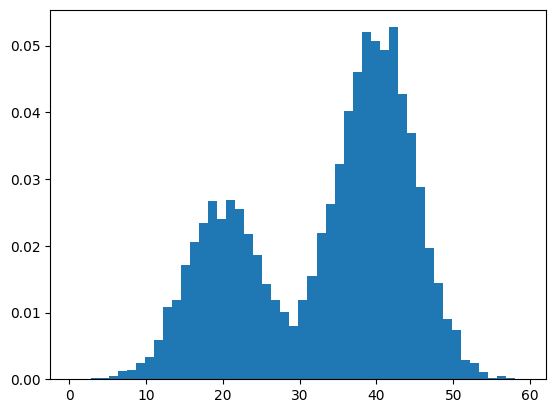

In [3]:
# Use data suggested by the Mastery site.
# Construct a bimodal from two Gaussian processes.
# Can K-means with K=2 reconstruct the 2 means?
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [4]:
# Choose not-quite-random initializers, k=2.
guess1 = 5
guess2 = 10
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
print('Initial means:',guess1,guess2)
new1,new2=iterative_2_means_delta(guess1,guess2,X,0.01)

Initial means: 5 10
Cluster sizes: 22 8978
Cluster SSE: 73 5933368
Cluster stdev: 0.39 0.27

New means: 5.85 33.43
Cluster sizes: 1391 7609
Cluster SSE: 148855 576538
Cluster stdev: 0.28 0.10
Diff: 5208048 Delta: 0.01

New means: 15.78 36.58
Cluster sizes: 2694 6306
Cluster SSE: 75555 239749
Cluster stdev: 0.10 0.08
Diff: 410089 Delta: 0.01

New means: 19.04 39.48
Cluster sizes: 2986 6014
Cluster SSE: 68327 145047
Cluster stdev: 0.09 0.06
Diff: 101930 Delta: 0.01

New means: 19.88 40.06
Cluster sizes: 3045 5955
Cluster SSE: 71820 136578
Cluster stdev: 0.09 0.06
Diff: 4976 Delta: 0.01

New means: 20.07 40.16
Cluster sizes: 3053 5947
Cluster SSE: 72510 135696
Cluster stdev: 0.09 0.06
Diff: 192 Delta: 0.01

New means: 20.09 40.17
Cluster sizes: 3054 5946
Cluster SSE: 72609 135594
Cluster stdev: 0.09 0.06
Diff: 3 Delta: 0.01

New means: 20.09 40.18
Cluster sizes: 3054 5946
Cluster SSE: 72609 135594
Cluster stdev: 0.09 0.06
Diff: 0 Delta: 0.01
